The purpose of this report is to display the charts for each of the 19 character pairs audited by both the graduate students and the automated process.

In [1]:
import IPython.display
import pandas as pd

audPre = pd.read_csv(
    'AuditsOriginal20190109.csv',
    header=None,
    names=['Original','Modified']
)
audPre = (
    audPre.groupby(['Original','Modified']).size()
    .reset_index(name='Counts')
    .sort_values('Counts', ascending=False)
    .reset_index(drop=True)
)

audPost = pd.read_csv(
    'AuditsRevised20190114.csv',
    header=None,
    names=['Original','Modified']
)
audPost = (
    audPost.groupby(['Original','Modified']).size()
    .reset_index(name='Counts')
    .sort_values('Counts', ascending=False)
    .reset_index(drop=True)
)

audCompare = (
    pd.merge(
        audPre, audPost, on=['Original','Modified'], how='inner'
    )
    .rename(
        index=str, columns={
            'Counts_x':'Pre Count',
            'Counts_y':'Post Count'
        }
    )
)
audCompare['Pairs'] = (
    audCompare['Original'] + "-" + audCompare['Modified']
)   
audCompare = (
    audCompare.set_index('Pairs')
    .drop(['Original','Modified'], axis=1)
)

audCompare['% Change'] = (
    audCompare['Post Count'].divide(audCompare['Pre Count'])
    .round(4) * 100
)
audCompare = (
    audCompare[audCompare['% Change'] > 100.0]
    .sort_values('% Change', ascending=False)
)
audCompare

,Pre Count,Post Count,% Change
Pairs,,,
郎-郞,140,5540,3957.14
謚-諡,124,1134,914.52
鎮-鎭,329,2106,640.12
尚-尙,882,5389,611.00
并-幷,172,983,571.51
真-眞,255,1186,465.10
慎-愼,160,685,428.12
荊-荆,129,503,389.92
偽-僞,164,603,367.68


In [15]:
allData = pd.read_csv(
    'AllTangAudits-2-26-19.csv',
    header=None,
    names=['Original','Modified','Chapter','Paragraph','StartLoc','Username']
)

In [10]:
import IPython.display
import pandas as pd
import numpy as np

# The initial variable holding pairs of characters being analyzed,
# as well as the dictionaries that will be used to contain DataFrames
# related to each pair of characters. Those DataFrames will then be
# used to display the results of each function.

characterPairs = audCompare.index # The first five character pairs
group = {} # Referenced in function: pairImport
userCounts = {} # Referenced in function: metricCounts
mutualChap = {} # Referenced in function: sharedChap

def sharedChap(i):
    '''Generate table of audited chapters shared between
    server and students.'''
    
    # The auditGroup DataFrame contains counts of audits per 
    # both chapter and user.
    
    auditGroup = (
        group[i].groupby(['Chapter','Username']).size()
        .reset_index(name='audit counts')
    )

    # The uniqueUsers list contains the names of users who submitted
    # audits for a particular pair of characters (group).
    # If the first user in the list is not "server," the values are
    # swapped to accommodate for displaying the automated process
    # first in all reports.
    
    uniqueUsers = group[i].Username.unique().tolist()
    
    if uniqueUsers[0] != 'server':
        a = uniqueUsers.index('server')
        uniqueUsers[0], uniqueUsers[a] = uniqueUsers[a], uniqueUsers[0]

    # The splitGroup dictionary holds DataFrames containing the audit
    # counts and chapters for a specific user.
    
    splitGroup = {}
    k = 0
    
    for u in uniqueUsers:
        splitGroup[k] = (
            auditGroup.loc[auditGroup['Username'] == u]
            [['Chapter','audit counts']]
        )
        k += 1

    # The merged dictionary holds DataFrames that are merged with
    # inner join to throw away any rows that are not shared between
    # the server and the user's list of audited chapters.
    
    merged = {}
    m = 1
    empClear = 0 # In case of an empty Dataframe, add to this number.
    
    while ( m < k ):
        merged[m - empClear] = (
            splitGroup[0].merge(
                splitGroup[m], 
                on='Chapter', 
                suffixes=(
                    '_{}'.format(uniqueUsers[0]),
                    '_{}'.format(uniqueUsers[m])
                )
            )
            .set_index('Chapter')
        )

        if merged[m - empClear].empty:
            del merged[m - empClear]
            empClear += 1

        m += 1

    # The mutualChap dictionary is then filled with the group's
    # concatenated DataFrame with all user's audits counts compared
    # with the server's own list, producing the desired report.
    # All NaN's are replaced with zeroes, converted to integers,
    # and then replaced with blank values for easier visibility.
    
    while ( m > 1 ):
        m -= 1
        mutualChap[i] = (
            pd.concat(merged, sort=False)
            .fillna(0)
            .astype(int)
        )
    
    # The resulting dictionary entry is then displayed to the user.
    
    #display(mutualChap[i])    

def metricCounts(i):
    '''Generate counts of chapters and audits per user.'''
    
    # The userCounts dictionary is assigned a DataFrame that includes
    # counts of each audited chapter per user, and total number of
    # audits per user, with appropriate column labels.
    
    userCounts[i] = (
        group[i]
        .groupby(['Chapter','Username'])['Paragraph'].agg('count')
        .reset_index(name='audit count')
        .groupby('Username')['audit count'].agg(['count','sum'])
        .rename(index=str,
                columns={'count':'chapter count', 'sum':'audit count'}
               )
    )
    
    # A new row is added to the DataFrame to display the percentage
    # of chapters audited by users, and of users' combined audits.
    
    userCounts[i].loc['% of Total'] = (0.0)
    userCounts[i].loc['% of Total'].at['chapter count'] = (
        (
            userCounts[i].iloc[1:,0].sum()
            / group[i].Chapter.nunique()
        )
        .round(3) * 100
    )
    userCounts[i].loc['% of Total'].at['audit count'] = (
        (
            userCounts[i].iloc[1:,1].sum()
            / userCounts[i].loc[:,'audit count'].sum()
        )
        .round(3) * 100
    )
    
    # The resulting dictionary entry is then displayed to the user.
    
    #display(userCounts[i])

def pairImport(i):
    '''Import the appropriate CSV file to the group dictionary.'''

    char1 = audCompare.index[i].split('-')[0]
    char2 = audCompare.index[i].split('-')[1]
    
    group[i] = allData.loc[
        (allData['Original'] == char1) 
        & (allData['Modified'] == char2)
    ].reset_index(drop = True)

In [11]:
# For producing charts the following modules are imported.
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from math import ceil
%matplotlib inline

prop = fm.FontProperties(
    fname = '/Users/jeffheller/anaconda3/Chinese Fonts'\
    '/Exported Fonts/LiHei Pro/LiHeiPro.ttf', size=20
)

def chartGroup (i):
    '''Generate swarmplots for chapters with a significant 
    number of mutual audits.'''

    # Reserve the column and user name for the server, to be used
    # in all generated charts.

    sColumnName = mutualChap[i].columns[0]
    sName = sColumnName.split('_', 1)[1]

    # Save the total number of columns (users) to a variable.

    columnCount = len(mutualChap[i].columns)

    # Set the initial plot parameters and title.
    
    fig = plt.figure(figsize=(columnCount * 2, 4))
    fig.suptitle(
        f'Excessiveness Test Group {i + 1}: {characterPairs[i]}', 
        y = 1.05, 
        fontproperties = prop
    )
    fig.text(0.5, 0, 'usernames', ha='center')

    # This loop creates a separate chart for each user in
    # comparison to the server.

    for x in range(1, columnCount):

        # The column and user name is reserved as their own variables.

        uColumnName = mutualChap[i].columns[x]
        uName = uColumnName.split('_', 1)[1]

        # Take the data of the server and the current user to be charted
        # to its own variable.

        charted = (mutualChap[i].loc[x][[sColumnName,uColumnName]]
                  .rename(index=str, columns={sColumnName: sName,
                                              uColumnName: uName})
                  )

        # Draw the subplots and label y axis if first.

        ax = plt.subplot(1, columnCount-1, x)
        if x == 1:
            ax.set_ylabel('count of audits')
        sns.swarmplot(data = charted)

        # For y-axis ticks, determine the maximum number of audits
        # for the charted pair, then divide by 10 and round up to
        # an integer to set its interval. Also add that number to the
        # maximum number to buffer the padding at the top of the chart.
        
        sMax = mutualChap[i].loc[x].max()[0]
        uMax = mutualChap[i].max()[x]
        maxValue = max(sMax, uMax)
        ceilMax = ceil(maxValue / 10)
        ax.set_yticks(
            np.arange(0, maxValue + ceilMax, ceilMax)
        )

        # In cases where the server replaced three or more characters
        # in a chapter, highlight the corresponding dots with a red box.

        if sMax > 3:
            rect = patches.Rectangle(
                (-0.4, 3.5), 
                width = 0.8, height = sMax - 2,
                linewidth = 1, edgecolor = 'r', facecolor = 'none')
            ax.add_patch(rect)

    plt.tight_layout()

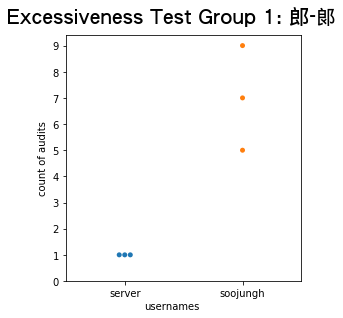

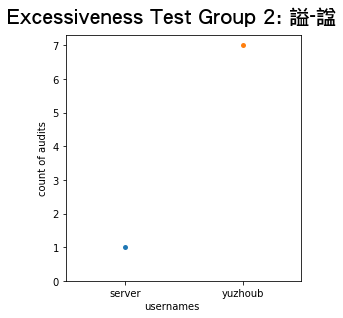

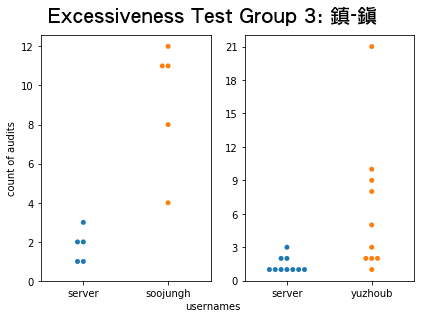

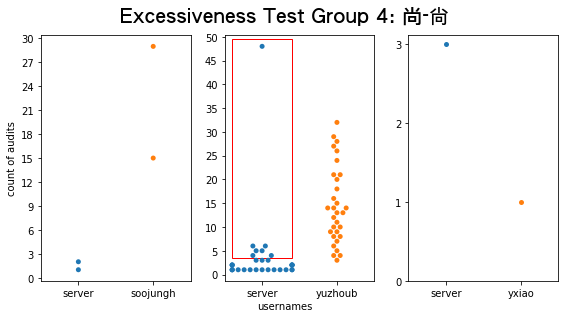

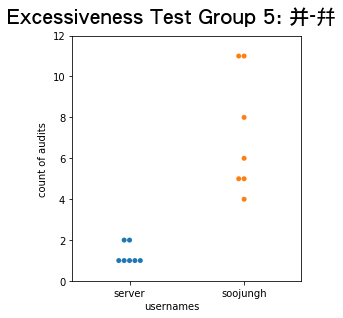

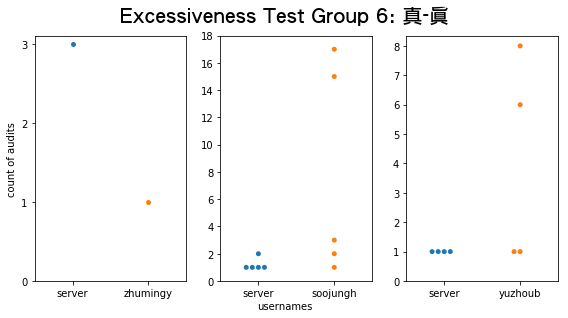

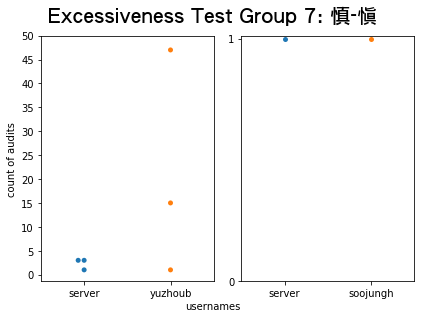

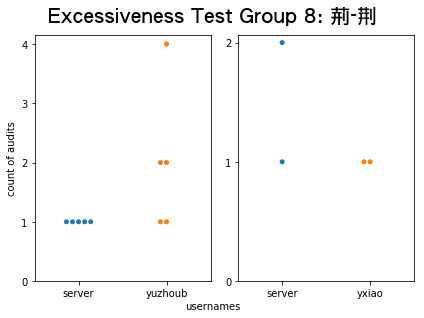

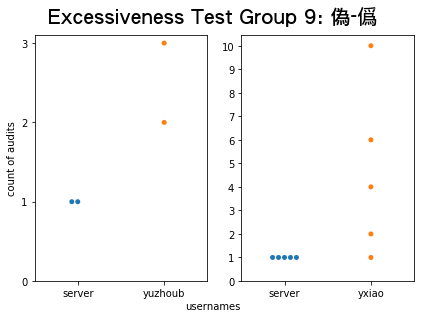

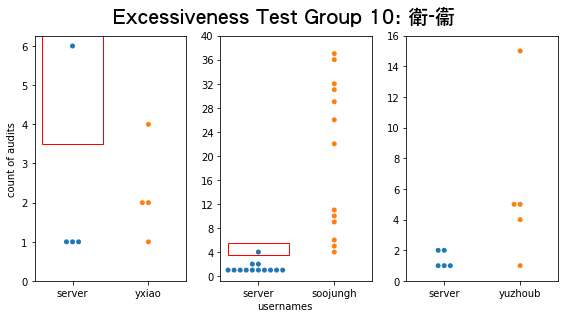

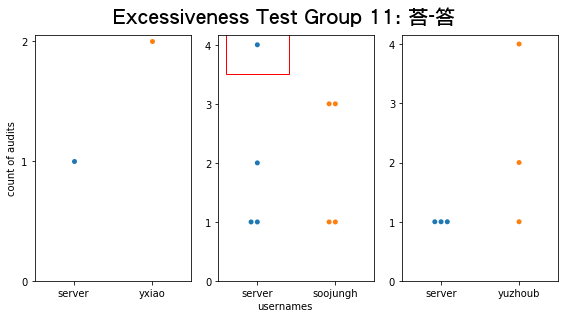

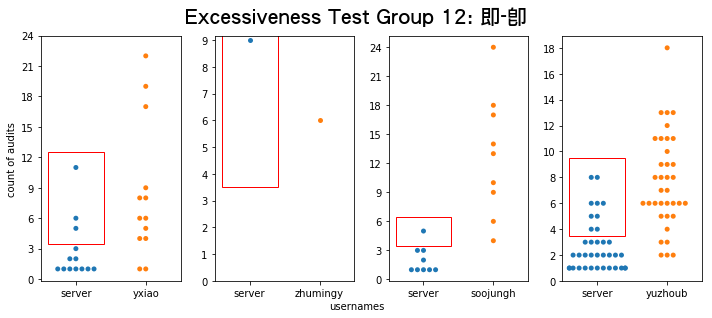

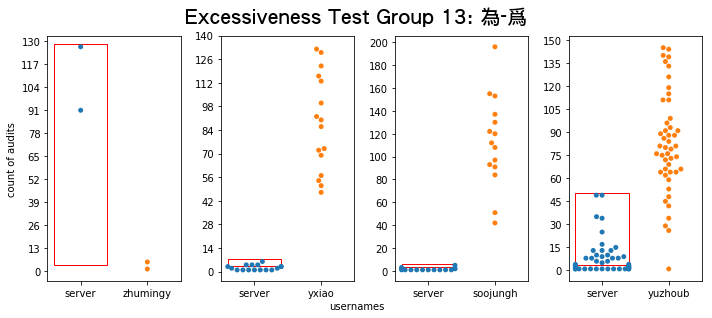

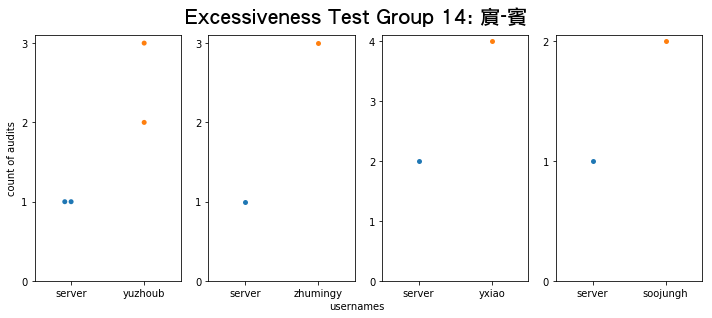

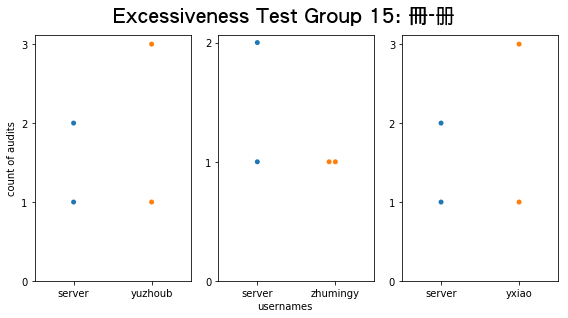

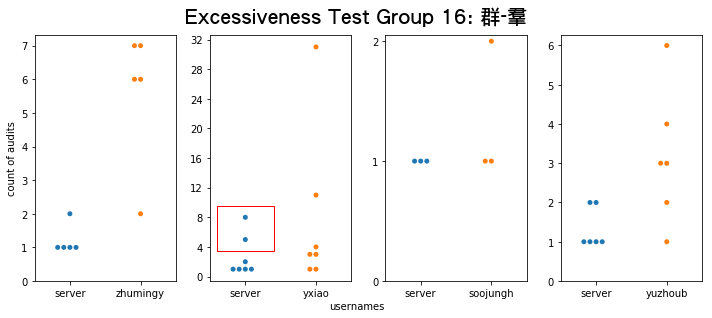

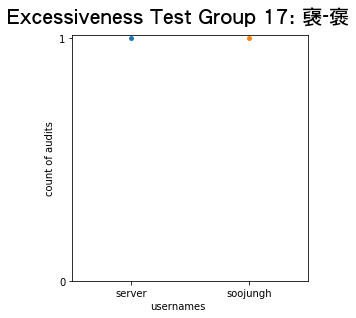

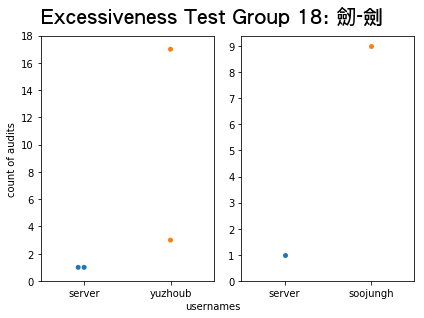

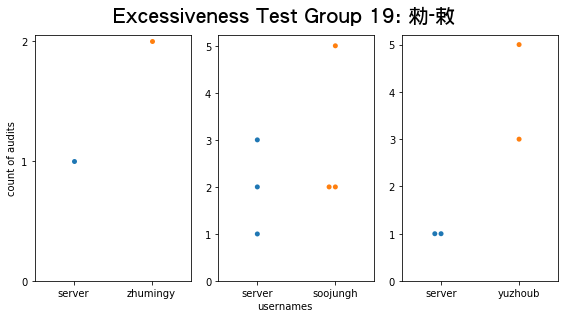

In [12]:
for i in range(0,len(audCompare.index)):
    pairImport(i)
    metricCounts(i)
    sharedChap(i)
    chartGroup(i)

In [18]:
test = allData.groupby(['Chapter','Paragraph','StartLoc']).count()
test = test.loc[test['Modified'] > 1]
test

Original  Modified  \
Chapter                            Paragraph StartLoc                       
JTS 102 — 卷一百零二   列傳第五十二           54        28               2         2   
JTS 121 — 卷一百二十一   列傳第七十一          20        63               2         2   
JTS 122 — 卷一百二十二   列傳第七十二          2         190              2         2   
                                   6         13               2         2   
                                   10        147              2         2   
                                   11        10               2         2   
                                   13        137              2         2   
                                   20        37               2         2   
                                             64               2         2   
JTS 123 — 卷一百二十三   列傳第七十三          9         121              2         2   
                                   10        43               2         2   
                                   18        56               2         2   
JTS 124 — 卷一百二十四   列傳第七十四 薛嵩       22        37               2         2   
JTS 141 — 卷一百四十一   列傳第九十一 田承嗣      9         112              2         2   
JTS 149 — 卷一百四十九   列傳第九十九          49        131              2         2   
JTS 194b — 卷一百九十四下   列傳第一百四十四下 突厥下 2         100              2         2   
JTS 195 — 卷一百九十五   列傳第一百四十五 廻紇     11        67               2         2   
JTS 198 — 卷一百九十八   列傳第一百四十八 西戎     18        92               2         2   
XTS 125 — 卷一百二十五   列傳第五十 蘇瓌　張說     4         18               2         2   
                                   6         30               2         2   
                                             91               2         2   
XTS 171 — 卷一百七十一   列傳第九十六          1         26               2         2   
XTS 178 — 卷一百七十八   劉蕡列傳第一百０三       1         82               2         2   
XTS 219 — 卷二百一十九   列傳第一百四十四 北狄     28        7                2         2   

                                                       Username  
Chapter                            Paragraph StartLoc            
JTS 102 — 卷一百零二   列傳第五十二           54        28               2  
JTS 121 — 卷一百二十一   列傳第七十一          20        63               2  
JTS 122 — 卷一百二十二   列傳第七十二          2         190              2  
                                   6         13               2  
                                   10        147              2  
                                   11        10               2  
                                   13        137              2  
                                   20        37               2  
                                             64               2  
JTS 123 — 卷一百二十三   列傳第七十三          9         121              2  
                                   10        43               2  
                                   18        56               2  
JTS 124 — 卷一百二十四   列傳第七十四 薛嵩       22        37               2  
JTS 141 — 卷一百四十一   列傳第九十一 田承嗣      9         112              2  
JTS 149 — 卷一百四十九   列傳第九十九          49        131              2  
JTS 194b — 卷一百九十四下   列傳第一百四十四下 突厥下 2         100              2  
JTS 195 — 卷一百九十五   列傳第一百四十五 廻紇     11        67               2  
JTS 198 — 卷一百九十八   列傳第一百四十八 西戎     18        92               2  
XTS 125 — 卷一百二十五   列傳第五十 蘇瓌　張說     4         18               2  
                                   6         30               2  
                                             91               2  
XTS 171 — 卷一百七十一   列傳第九十六          1         26               2  
XTS 178 — 卷一百七十八   劉蕡列傳第一百０三       1         82               2  
XTS 219 — 卷二百一十九   列傳第一百四十四 北狄     28        7                2